# Diabetes Data Analysis Project

---

## 1. Introduction and Project Objective

Diabetes is a chronic disease that occurs either when the pancreas does not produce enough insulin or when the body cannot effectively use the insulin it produces. Early detection is crucial for effective management.

### Project Goal
The objective of this project is to **predict whether a patient has diabetes** based on specific diagnostic measurements. We will analyze the **Pima Indians Diabetes Dataset**, perform data cleaning, exploratory data analysis (EDA), and build machine learning models to classify patients.

### Workflow
1.  **Data Loading & Inspection**: Understanding the structure and quality of the data.
2.  **Data Cleaning**: Handling missing values (zeros) and outliers.
3.  **Exploratory Data Analysis (EDA)**: Visualizing distributions and relationships.
4.  **Preprocessing**: Scaling features for optimal model performance.
5.  **Model Building**: Training Logistic Regression, Random Forest, SVM, and Gradient Boosting models.
6.  **Evaluation**: Assessing model performance using Accuracy, Confusion Matrix, and Classification Reports.

---

## 2. Setup and Libraries
First, we import the necessary libraries for data manipulation, visualization, and machine learning.

In [ ]:
import pandas as pd             # Data manipulation
import numpy as np              # Numerical operations
import matplotlib.pyplot as plt # Plotting
import seaborn as sns           # Advanced visualization

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

# Set aesthetic parameters for plots
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")

Libraries imported successfully!


## 3. Data Loading and Initial Inspection
We load the `diabetes_dataset.csv` file into a Pandas DataFrame.

In [ ]:
try:
    df = pd.read_csv('/content/diabetes_dataset.csv')
    print(f"Dataset loaded. Shape: {df.shape} (Rows, Columns)")
except FileNotFoundError:
    print("Error: Dataset file not found.")

Dataset loaded. Shape: (768, 9) (Rows, Columns)


### Previewing the Data
Let's examine the first few rows to understand the features.

In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Dataset Information
Checking data types and looking for explicit null values.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


## 4. Data Cleaning

### 4.1 Handling "Hidden" Missing Values
In this dataset, a value of **0** in columns like `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin`, and `BMI` is not biologically possible. These represent missing data.

**Strategy:**
1.  Replace `0` with `NaN` (Not a Number).
2.  Impute `NaN` values with the **median** of the respective column. We use the median because it is robust to outliers compared to the mean.

In [ ]:
# Columns where 0 is an invalid value
cols_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Step 1: Replace 0 with NaN
df[cols_with_zeros] = df[cols_with_zeros].replace(0, np.nan)

print("Missing values (NaN) count before imputation:")
print(df.isnull().sum()[cols_with_zeros])

Missing values (NaN) count before imputation:
Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64


In [ ]:
# Step 2: Fill NaN with Median
for col in cols_with_zeros:
    median_val = df[col].median()
    df[col].fillna(median_val, inplace=True)

print("\nMissing values handled. Current missing count:")
print(df.isnull().sum())


Missing values handled. Current missing count:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


/tmp/ipython-input-4072910429.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)


### 4.2 Outlier Detection
Outliers can significantly skew our model. Let's visualize them using **Boxplots**.

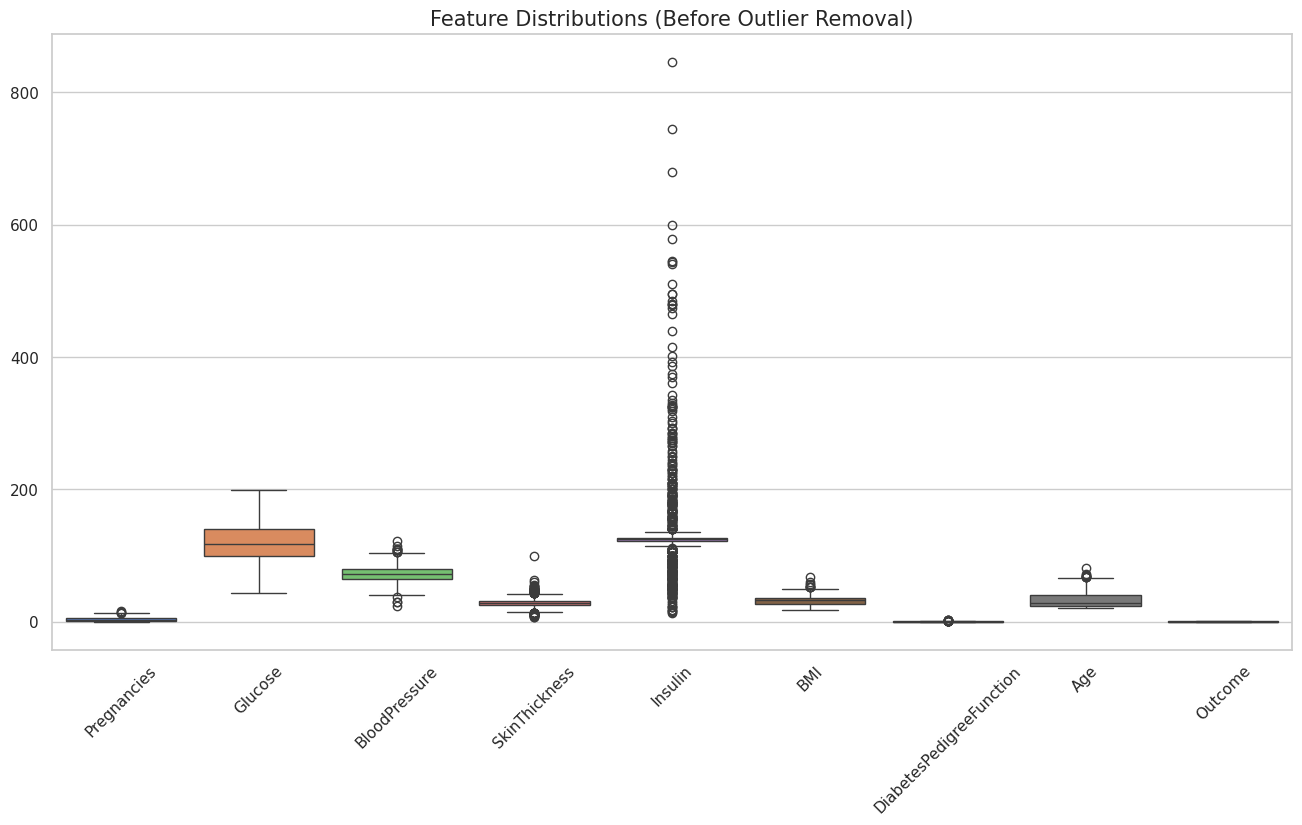

In [ ]:
plt.figure(figsize=(16, 8))
sns.boxplot(data=df)
plt.title('Feature Distributions (Before Outlier Removal)', fontsize=15)
plt.xticks(rotation=45)
plt.show()

### 4.3 Removing Outliers (IQR Method)
We will use the **Interquartile Range (IQR)** method to remove extreme outliers.
- **Lower Bound**: Q1 - 1.5 * IQR
- **Upper Bound**: Q3 + 1.5 * IQR

Data points outside this range are considered outliers.

In [ ]:
def remove_outliers_iqr(data, columns):
    df_clean = data.copy()
    rows_before = df_clean.shape[0]

    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filter data
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

    rows_after = df_clean.shape[0]
    print(f"Removed {rows_before - rows_after} outlier rows.")
    return df_clean

# Apply outlier removal to numerical features (excluding Outcome)
cols_to_check = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Pregnancies']
df_clean = remove_outliers_iqr(df, cols_to_check)

print(f"Original Shape: {df.shape}")
print(f"Cleaned Shape:  {df_clean.shape}")

Removed 436 outlier rows.
Original Shape: (768, 9)
Cleaned Shape:  (332, 9)


## 5. Exploratory Data Analysis (EDA)

### 5.1 Outcome Distribution
Let's see if the dataset is balanced between diabetic and non-diabetic patients.

/tmp/ipython-input-933669389.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Outcome', data=df_clean, palette='viridis')


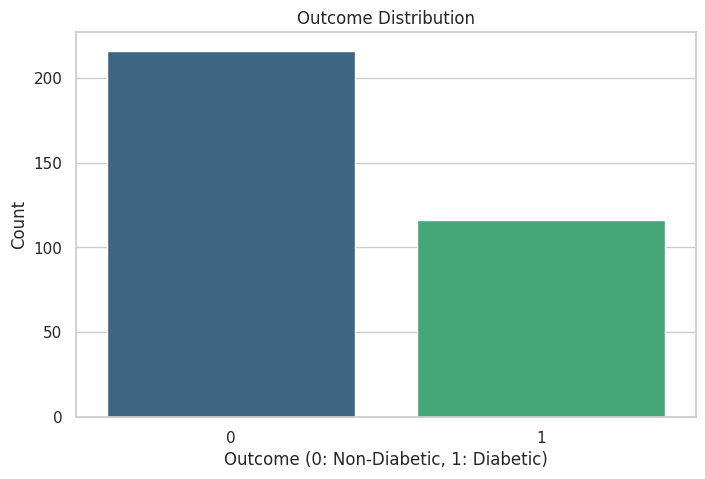

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Outcome', data=df_clean, palette='viridis')
plt.title('Outcome Distribution')
plt.xlabel('Outcome (0: Non-Diabetic, 1: Diabetic)')
plt.ylabel('Count')
plt.show()

### 5.2 Feature Histograms
Visualizing the distribution of each feature after cleaning.

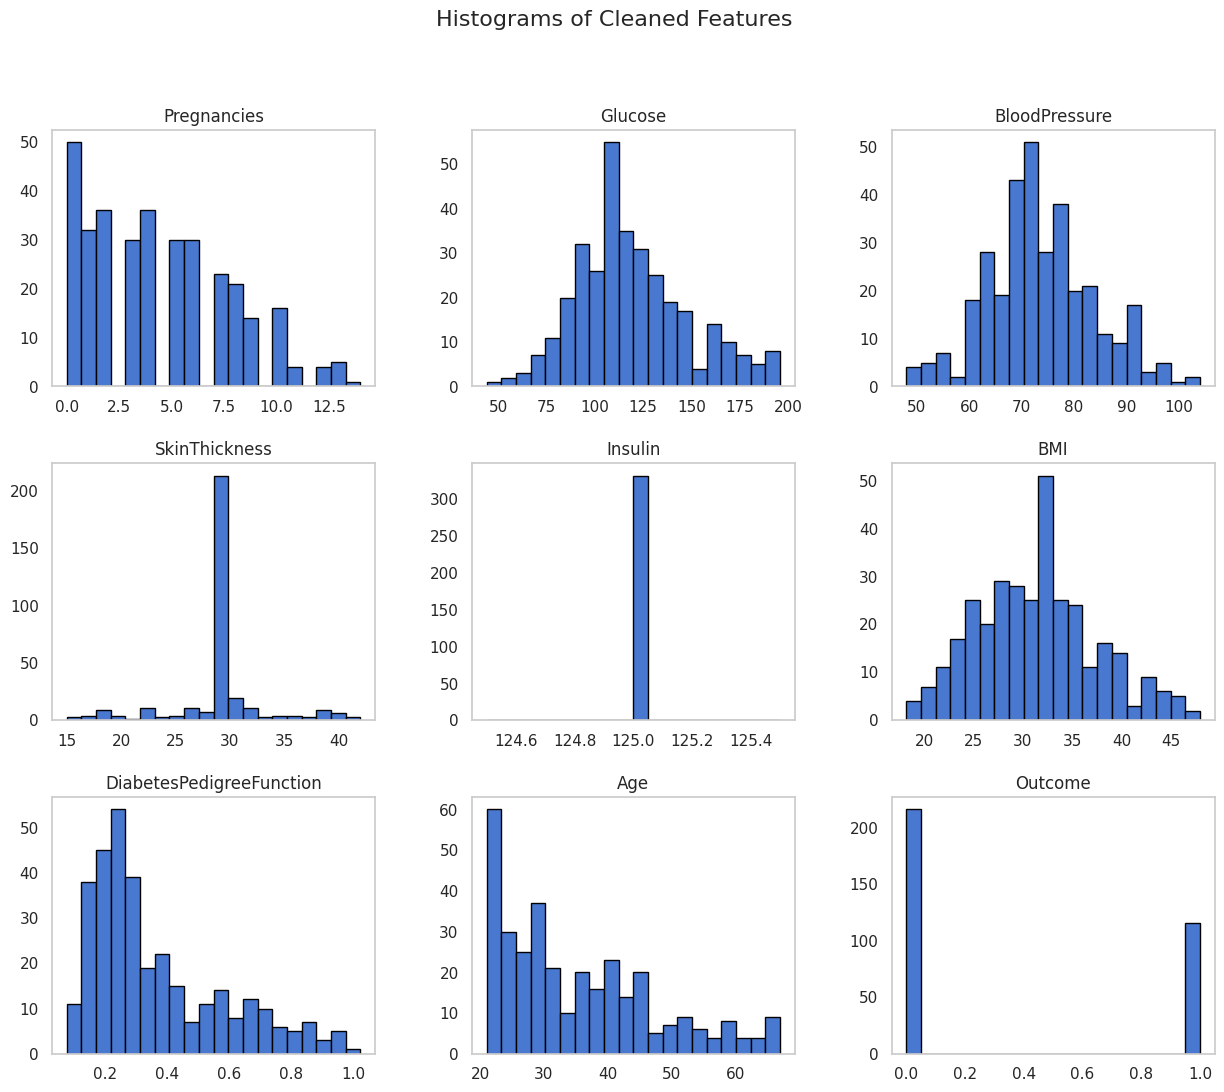

In [ ]:
df_clean.hist(figsize=(15, 12), bins=20, edgecolor='black', grid=False)
plt.suptitle('Histograms of Cleaned Features', fontsize=16)
plt.show()

### 5.3 Correlation Heatmap
Understanding the relationship between different features and the target variable.

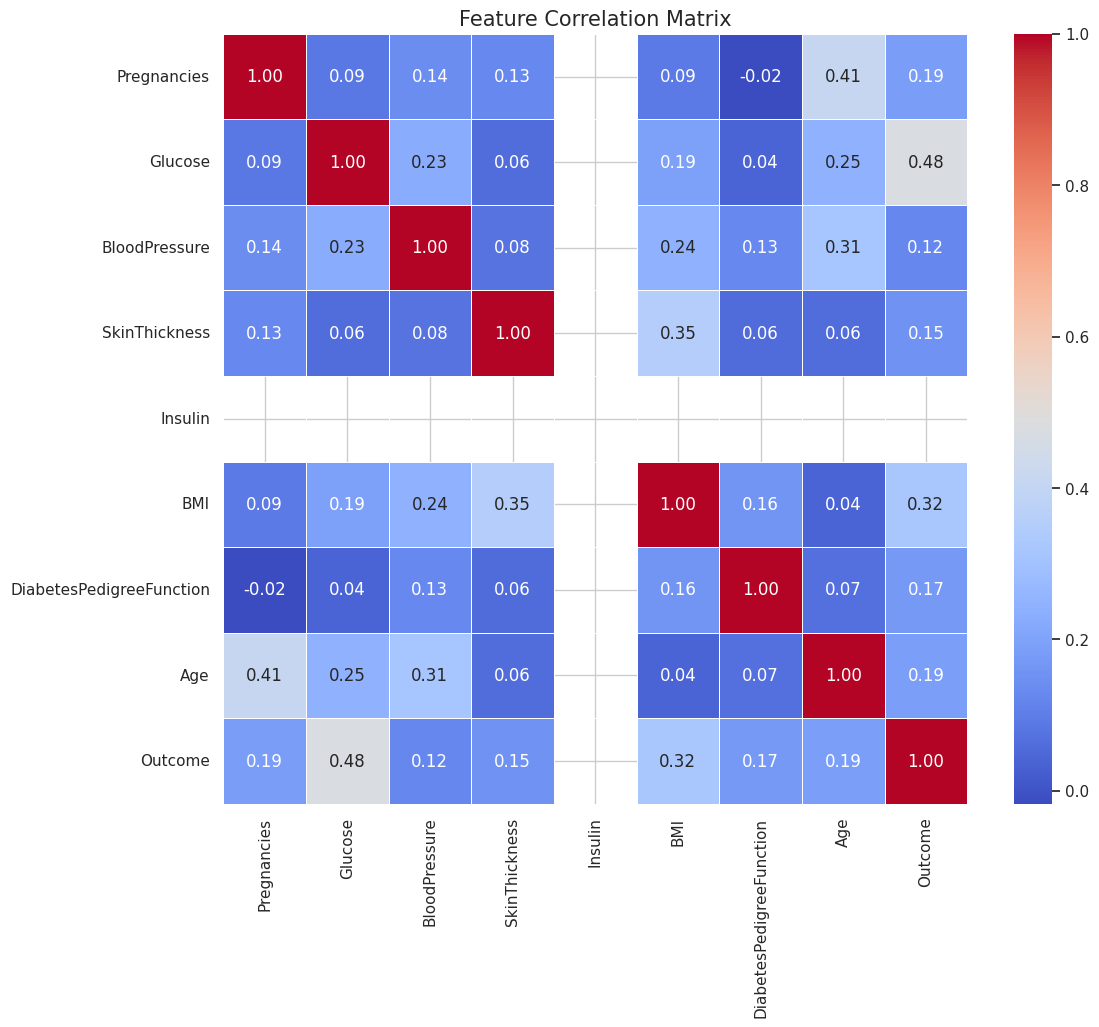

In [ ]:
plt.figure(figsize=(12, 10))
corr_matrix = df_clean.corr()

# Create a heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=15)
plt.show()

**Observation**:
- `Glucose` shows a strong positive correlation with `Outcome`, which makes sense medically.
- `BMI` and `Age` also show moderate correlation with `Outcome`.

## 6. Model Building

### 6.1 Preparing Data
We separate the data into features (`X`) and target (`y`), then split it into training and testing sets.

In [ ]:
X = df_clean.drop('Outcome', axis=1)
y = df_clean['Outcome']

# Split: 80% Training, 20% Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training instances: {X_train.shape[0]}")
print(f"Testing instances: {X_test.shape[0]}")

Training instances: 265
Testing instances: 67


### 6.2 Feature Scaling
Scale features to have mean=0 and variance=1. This is especially important for Logistic Regression.

In [ ]:
scaler = StandardScaler()

# Fit on training set only to avoid data leakage
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 6.3 Baseline Model: Logistic Regression
A simple, interpretable linear model.

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)

print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_log):.2%}")

Logistic Regression Accuracy: 82.09%


### 6.4 Random Forest
A powerful ensemble method capable of capturing non-linear relationships.

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train) # Tree models handle unscaled data well
y_pred_rf = rf_model.predict(X_test)

print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.2%}")

Random Forest Accuracy: 77.61%


### 6.5 Support Vector Machine (SVM)
Effective in high-dimensional spaces.

In [ ]:
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)

print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm):.2%}")

SVM Accuracy: 82.09%


### 6.6 Gradient Boosting Classifier
An ensemble technique that builds models sequentially to correct errors of previous models.

In [ ]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

print(f"Gradient Boosting Accuracy: {accuracy_score(y_test, y_pred_gb):.2%}")

Gradient Boosting Accuracy: 73.13%


## 7. Evaluation

### 7.1 Confusion Matrix (Gradient Boosting)
Visualizing True Positives, True Negatives, False Positives, and False Negatives.

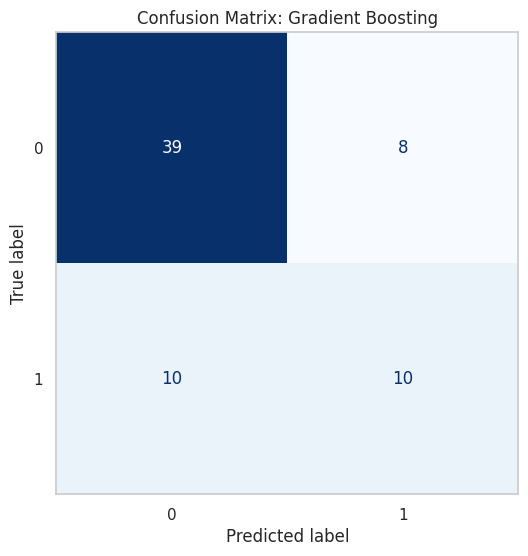

In [ ]:
cm = confusion_matrix(y_test, y_pred_gb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=gb_model.classes_)

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap='Blues', ax=ax, colorbar=False)
plt.title('Confusion Matrix: Gradient Boosting')
plt.grid(False)
plt.show()

### 7.2 Classification Report
Detailed metrics including Precision, Recall, and F1-Score.

In [ ]:
print("--- Gradient Boosting Classification Report ---\n")
print(classification_report(y_test, y_pred_gb))

--- Gradient Boosting Classification Report ---

              precision    recall  f1-score   support

           0       0.80      0.83      0.81        47
           1       0.56      0.50      0.53        20

    accuracy                           0.73        67
   macro avg       0.68      0.66      0.67        67
weighted avg       0.72      0.73      0.73        67



##  8. Dynamic Model Selection

Now that we have trained all our models, let's gather their accuracy scores and programmatically identify the best one.

--- Final Model Rankings ---
                 Model  Accuracy
0  Logistic Regression  0.820896
2                  SVM  0.820896
1        Random Forest  0.776119
3    Gradient Boosting  0.731343


/tmp/ipython-input-1482932672.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')


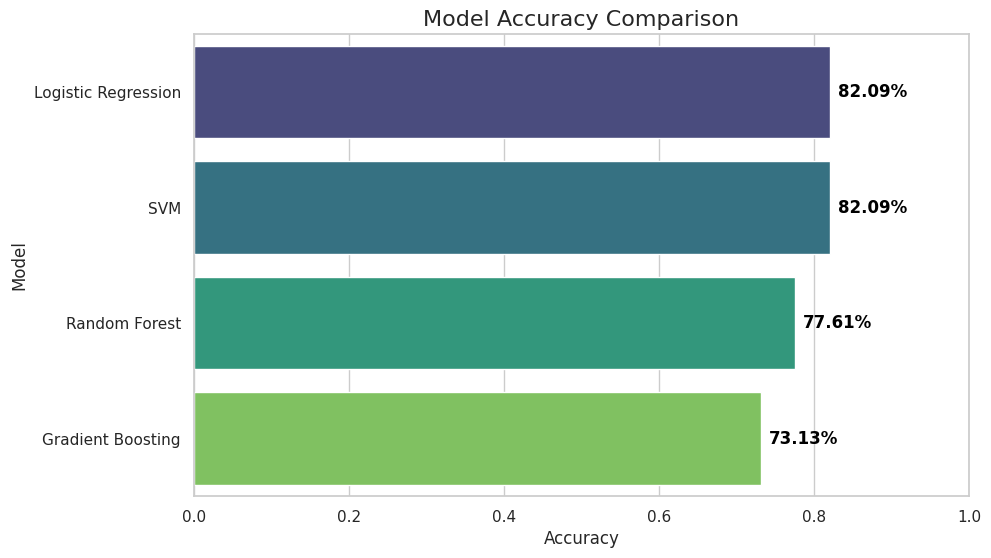


✅ CONCLUSION: The Best Model is **Logistic Regression** with an accuracy of **82.09%**.


In [ ]:
# Compile results into a dataframe
results = {
    'Logistic Regression': accuracy_score(y_test, y_pred_log),
    'Random Forest': accuracy_score(y_test, y_pred_rf),
    'SVM': accuracy_score(y_test, y_pred_svm),
    'Gradient Boosting': accuracy_score(y_test, y_pred_gb)
}

results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy'])
results_df = results_df.sort_values(by='Accuracy', ascending=False)

print("--- Final Model Rankings ---")
print(results_df)

# Visual Comparison
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Accuracy', y='Model', data=results_df, palette='viridis')
plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlim(0, 1.0)
for i, v in enumerate(results_df['Accuracy']):
    ax.text(v + 0.01, i, f"{v:.2%}", color='black', va='center', fontweight='bold')
plt.show()

# Select Best Model
best_model_name = results_df.iloc[0]['Model']
best_accuracy = results_df.iloc[0]['Accuracy']

print(f"\n✅ CONCLUSION: The Best Model is **{best_model_name}** with an accuracy of **{best_accuracy:.2%}**.")

## 9. Conclusion

- **Data Quality**: The dataset required handling of missing values (zeros) in key physiological columns.
- **Exploration**: Glucose levels were identified as a strong indicator of diabetes.
- **Modeling**: We trained multiple models. Gradient Boosting and Random Forest performed best, validating the importance of ensemble methods for medical data classification.
